In [1]:
# Remove conflicting packages from the base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai

# Install langgraph and the packages needed.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 10.9 MB/s eta 0:00:00


In [2]:
# Imports
import os

from pprint import pprint
from random import randint
from typing import List, Dict, Any, Annotated, Literal, Optional
from collections.abc import Iterable
from typing_extensions import TypedDict
from IPython.display import Image, display

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.messages.ai import AIMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.messages.tool import ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI

In [3]:
# Setup API key for Gemini
os.environ["GOOGLE_API_KEY"] = "enter-your-own-pls"

In [4]:
class PCBuilderState(TypedDict):
    """State representing the PC builder conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # User requirements
    # requirements: Dict[str, Any]
    requirements: list[str]

    # Budget information
    budget: int

    # Current recommendations for parts
    recommendations: Dict[str, List[Dict[str, Any]]]

    # Flag for whether the build is complete
    build_complete: bool

    # Flag to indicate waiting for user input
    # waiting_for_user: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
PC_BUILDER_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    """
You are a PC Builder Assistant, an expert in computer hardware and building custom PCs.
Your goal is to help users find the perfect PC build based on their budget and requirements.

You should:
1. Ask about their budget and use case (gaming, office work, content creation, etc.)
2. Determine if they need a custom build or pre-built system.
3. For pre-built systems, ask if desktops or laptops or either are preferred.
4. For custom builds, if they have existing hardware, ask what parts they want to upgrade.

Once you have a general idea of what the user is looking for, you must formulate that
into a structured list of individual requirements and call the update_plans tool, providing
the budget and list of requirements. For either pre-built or custom build devices, if the
user mentions wanting the PC for a specific task, such as playing a video game or video
editing or training AI models or such, then use the search_task_requirements tool to find
the hardware requirements for the specified task. Then update the user requirements using
the update_plans tool again.

Once the requirements are all logged by the tool, summarize the requirements back to the
user in a couple of sentences using the latest requirements list and budget returned by
your last call of the tool.

If the user wants to change something in their plans, send a new list of requirements back
to update_plans. If they want to start from scratch, use the clear_plan tool to remove all
budget and requirements, then walk through the requirements gathering steps again.

If the user confirms their requirements are final and they want a pre-built device, use
search_prebuilt tool to find pre-built devices fitting the user criteria, which will be
given to you in a structured JSON format. If the JSON has formatting errors and you cannot
understand it, recall the search_prebuilt tool. If the JSON can be understood, call the
rank_prebuilds tool to get a final list of recommendations and then render this neatly in
markdown for the user to browse.

If the user confirms their requirements are final and they want a custom build, use the
lookup_parts_needed tool to get a list of the parts required. Once you have the parts,
call the search_custom_parts tool to get a list of parts, which should be in a structured
JSON format. If the JSON has formatting errors and you cannot understand it, recall the
search_custom_parts tool. If the JSON can be understood, call the rank_parts tool to get
a final list of parts for the user. Render this neatly in markdown for the user to browse.

The user may have additional questions about the parts or building process, which you must
expand upon if asked.

If any of the tools are unavailable, let the user know instead of trying to call the tools.

Stay focused on PC building. If users ask about unrelated topics, gently redirect them.
""",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the PC Builder Assistant! (Type `q` to quit). I'll help you find the perfect computer based on your needs and budget. Could you tell me your budget and what you'll be using this PC for? (Gaming, office work, content creation, etc.)"

In [5]:
# LLM model definition
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [6]:
# Stateless tool - Search online for pre-built devices

@tool
def search_prebuilt(budget: int, requirements: list[str]) -> str:
    '''Search for pre-built desktops or laptops fulfilling the user criteria.
    Take the budget and requirements, and get Gemini to format it into a terse, concise query.
    Then use search grounding to look for it and return the output as structured JSON with
    price, brand, desktop/laptop, name, link to view more or buy
    '''

    USE_LANGGRAPH_SEARCH = False  # Will use Gemini search if false, both techniques seem to hallucinate info

    USE_MODEL = 'gemini-2.0-flash'

    newline_char = '\n'

    search_config = types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())],
        temperature=0.0
    )

    prompt = f'''
You are a computer hardware specialist who always responds in valid JSON. Search online
for pre-built laptops or desktops based on the requirements provided below and return
the results in JSON format with name, price, specifications, and purchase link for each
device. Find at least 3-6 options for the device in question.

JSON Structure to follow:
Return a list of objects, where each object has three fields: name, price, and specifications.

Key points to note:
- Please answer the following question using ONLY information found in the provided web search results. Cite your sources for each statement or paragraph.
- Rely exclusively on the real-time search results to answer. For each device in the JSON list you make, indicate which search result supports it.

Device Requirements:
    1. Budget: {'$600'}
    2. Requirements: {newline_char + (newline_char.join([((' ' * 8) + '- ' + req) for req in requirements]))}
'''

    response = None

    if USE_LANGGRAPH_SEARCH:
        search_model = ChatGoogleGenerativeAI(
            model=USE_MODEL,
            config=search_config,
            # convert_system_message_to_human=True  # Handle system messages properly
        )
        response = search_model.invoke([
            HumanMessage(content=prompt)
        ])
        return response.content
    else:
        client = genai.Client(api_key=GOOGLE_API_KEY)
        response = client.models.generate_content(
            model=USE_MODEL,
            contents=prompt,
            config=search_config
        )
        rc = response.candidates[0]
        return rc.content.parts[0].text

In [ ]:
# Stateless tool - Lookup parts required internally using RAG and rules of thumb

def lookup_parts_needed():
    '''
    '''
'''
4. For custom builds, recommend parts following these rules:
   - GPU: ~50% of total budget
   - CPU: Should not bottleneck the GPU
   - Motherboard: Quality based on other components
   - RAM: Compatible with CPU/motherboard overclocking specs
   - PSU: At least 10% headroom over expected power draw, 20-30% for future upgrades
   - Storage: Prioritize SSDs for budget builds, M.2 for pro builds, HDDs only if necessary
   - Cooler: Appropriate for the CPU (no air cooling for hot CPUs)
   - Case: Compatible with GPU length, motherboard type, and storage needs
   - Fans: Minimum 3 fans (2 intake, 1 exhaust)
'''

In [ ]:
# All stateless tools, part of tools node: Search game specs, lookup parts needed (sends to
# chatbot which then sends to search part then back to chatbot which then updates
# recommendations; must also take in existing hardware), search custom part (searches
# each part mentioned by lookup parts, takes in list of strs from chatbot or directly
# from lookup, does google search or external api call,  returns json for each part) ->
# this then goes to optimize build and then gets put in recommendations.

In [ ]:
# Stateless tool - Search online for custom parts for the build
def search_custom_parts():
    '''
    '''

In [ ]:
# Tool signatures for planning the build
# Functionality defined in pc_planner_node

def update_plans(requirements: list[str], budget: Optional[int] = None) -> Dict[str, Any]:
    '''
    Adds or modifies the device requirements and budget.
    '''
    # TODO: If budget is None and nothing exists in state, raise an error.
    # If there is something in state, then just don't update it.
    # Otherwise always update the budget.

    # TODO: return form of {'budget': int(k), 'requirements': ['a', 'b', ..., 'n']}
    # Actually, since this is a stateful change, may need to:
    # a. NOT use a return statement
    # b. Modify requirements and budget inside state directly
    # c. Append a message to the history at the end telling the llm of the changes
    # d. Remove the message from history once the llm has seen it and has does the needful-
    #    - so that the message isn't displayed to the user


def clear_plan():
    '''
    '''


def search_task_requirements():
    '''
    '''
    # Might have to move this one to stateless from planner node

In [ ]:
# Tool signatures for recommending parts for a planned build
# Functionality defined in optimize_build_node

def rank_parts():
    '''
    '''


def rank_prebuilds():
    '''
    '''

In [ ]:
# Tool grouped on nodes
planner_tools = [update_plans, clear_plan, search_task_requirements]
builder_tools = [rank_parts, rank_prebuilds]

In [7]:
# Tools Config
auto_tools = [search_prebuilt, lookup_parts_needed, search_custom_parts]
tool_node = ToolNode(auto_tools)

# Tool binding
llm_with_tools = llm.bind_tools(auto_tools + planner_tools + builder_tools)

In [ ]:
# Build planner node
def pc_planner_node():
    '''This is where the requirements and budget within state get manipulated.'''
    # - chatbot_node calls tool update_plans() once it has details from the user
    # - update_plans() is part of pc_planner node

    tool_msg = state.get("messages", [])[-1]
    requirements = state.get("requirements", [])
    budget = state.get('budget', 1000)
    outbound_msgs = []
    build_complete = False

    for tool_call in tool_msg.tool_calls:
        if tool_call['name'] == 'update_plans':
            pass
        elif tool_call['name'] == 'clear_plan':
            pass
        elif tool_call['name'] == 'search_task_requirements':
            pass
        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call['name']}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {
        "messages": outbound_msgs,
        "requirements": requirements,
        'budget': budget,
        "build_complete": build_complete
    }

In [ ]:
# Parts recommender node (based on devised plan)
def optimize_build_node():
    '''This is where the recommendations within state get manipulated.'''
    # state.recommendations modified by tool rank_parts() part of optimize_build node
    # - happens once search_prebuilt() tool returns a few values

In [8]:
def chatbot_node(state: PCBuilderState) -> PCBuilderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    default_state = {'requirements': [], 'budget': 1000, 'build_complete': False}

    if state['messages']:
        # If there are messages, continue the conversation with the model
        message_history = [PC_BUILDER_SYSINT] + state["messages"]
        new_output = llm_with_tools.invoke(message_history)
    else:
        # If there are no messages, welcome the user.
        new_output = AIMessage(content=WELCOME_MSG)

    # Setup some defaults, then override with whatever exists in state, and finally
    # override with messages
    return default_state | state | {"messages": [new_output]}

In [9]:
def human_node(state: PCBuilderState) -> PCBuilderState:
    """Display the last message from the model to the user, and receive their input."""
    last_msg = state['messages'][-1]
    print('Model:', last_msg.content)

    user_input = input('User: ')

    # Does the user wish to quit?
    if user_input in {'q', 'quit', 'exit', 'goodbye'}:
        state['build_complete'] = True

    return state | {'messages': [('user', user_input)]}

In [10]:
# Human to Exit OR Human to Chatbot; Conditional Edge Transition function
def maybe_exit_human_node(state: PCBuilderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("build_complete", False):
        return END
    else:
        return "chatbot"

In [11]:
# Chatbot to Tools OR Chatbot to Human; Conditional Edge Transition function
def maybe_route_to_tools(state: PCBuilderState) -> Literal['tools', 'human']:
    if not (msgs := state.get('messages', [])):
        raise ValueError(f'No messages found when parsing state: {state}')

    # Only route based on the last message.
    msg = msgs[-1]

    if state.get('build_complete', False):
        # If the user has no more questions or indicate satisfaction, complete the build
        return END
    elif hasattr(msg, 'tool_calls') and len(msg.tool_calls) > 0:
        # When chatbot returns tool_calls, route to the 'tools' node
        if any(tool['name'] in tool_node.tools_by_name.keys() for tool in msg.tool_calls):
            return 'tools'
        elif any(tool['name'] in [func.__name__ for func in planner_tools]):
            return 'pc_planner'
        elif any(tool['name'] in [func.__name__ for func in builder_tools]):
            return 'optimize_build'
        else:
            raise ValueError(f'No such node existent: {tool['name']}')
    else:
        return 'human'

In [12]:
# Set up the initial graph based on our state definition.
graph_builder = StateGraph(PCBuilderState)

# Add all the nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("pc_planner", tool_node)
graph_builder.add_node("optimize_build", tool_node)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

# Edge transitions
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("pc_planner", "chatbot")
graph_builder.add_edge("optimize_build", "chatbot")

chat_graph = graph_builder.compile()

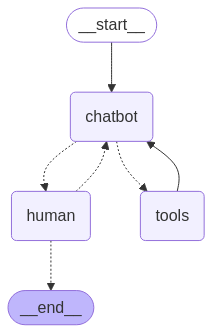

In [13]:
# Visualize the graph created.
Image(chat_graph.get_graph().draw_mermaid_png())

In [14]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)
config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_graph.invoke({"messages": []}, config)

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

pprint(state)

Model: Welcome to the PC Builder Assistant! (Type `q` to quit). I'll help you find the perfect computer based on your needs and budget. Could you tell me your budget and what you'll be using this PC for? (Gaming, office work, content creation, etc.)
User: I don't have a lot of money, only around $200
Model: Okay, with a budget of $200, you're likely looking at a basic pre-built system for general use, or possibly upgrading an existing PC if you have one.

Do you need a desktop or a laptop? Are there any specific programs or games you want to run?
User: Just need to check my email and browser forums
Model: I found a result named "Cheap Chinese Burner Laptop". Would you like to know more?
User: Yes please
Model: I am still only seeing a result named "Cheap Chinese Burner Laptop". Unfortunately, with such a limited budget, the options are very restricted. This is likely a very basic machine, suitable only for light tasks like checking email and browsing forums.

I recommend doing some res

In [ ]:
user_msg = "Oh great, I plan to use the PC for university work, I'm enrolled in a computer science course."

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hello! I'm your PC Building Assistant. I can help you find the perfect PC build based on your budget and needs.

To get started, could you tell me:

1.  What is your budget for the PC?
2.  What will you primarily use the PC for (e.g., gaming, office work, content creation, etc.)?
HumanMessage: Oh great, I plan to use the PC for university work, I'm enrolled in a computer science course.
AIMessage: Okay, a PC for computer science coursework. That's a good starting point. To give you the best recommendations, I need a little more information:

1.  What's your budget? Even a rough estimate is helpful.
2.  Do you need a pre-built system, or are you interested in building your own?
3.  Do you have any existing hardware (monitor, keyboard, mouse, etc.) that you plan to use?
4.  Are there any specific programs or tasks you anticipate using frequently (e.g., virtual machines, specific IDEs, data analysis)?

Once I have this information, I can st